<a href="https://colab.research.google.com/github/vasudhab21/ML-LAB/blob/main/ML_Lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

project_path = '/content/drive/MyDrive/GenomeDetector'
natural_data_path = os.path.join(project_path, 'data', 'natural2')
engineered_data_path = os.path.join(project_path, 'data', 'engineered')

!pip install biopython

print("Environment is ready. Paths are set to your 'natural2' and 'engineered' folders.")

Mounted at /content/drive
Environment is ready. Paths are set to your 'natural2' and 'engineered' folders.


In [ ]:
import numpy as np
from itertools import product
from Bio import SeqIO
import glob
import os
import gzip

def get_kmer_features(k):
    """Generates all possible k-mers for a given k."""
    letters = ['A', 'C', 'G', 'T']
    return sorted([''.join(p) for p in product(letters, repeat=k)])

def sequence_to_kmer_counts(sequence, k, kmer_features):
    """Converts a DNA sequence into a vector of k-mer counts."""
    kmer_counts = {kmer: 0 for kmer in kmer_features}
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k].upper()
        if kmer in kmer_counts:
            kmer_counts[kmer] += 1
    return list(kmer_counts.values())

# --- Main Loading Logic ---
print("--- Loading and Processing Your Datasets ---")
K_VALUE = 4
kmer_features = get_kmer_features(K_VALUE)
X, y = [], []

# 1. Load Natural Data from 'natural2' (handles .fna and .fna.gz)
print("Loading 'Natural' genomes from the 'natural2' folder...")
# The '*' wildcard finds files ending in .fna or .fna.gz
search_pattern_natural = f"{natural_data_path}/*.fna*"
natural_files = glob.glob(search_pattern_natural)

for filepath in natural_files:
    # Open the file correctly, whether it's gzipped or not
    handle = gzip.open(filepath, "rt") if filepath.endswith(".gz") else open(filepath, "r")
    for record in SeqIO.parse(handle, "fasta"):
        if len(record.seq) > 1000:
            X.append(sequence_to_kmer_counts(str(record.seq), K_VALUE, kmer_features))
            y.append(0) # Label 0 for Natural
    handle.close()

# 2. Load Engineered Data from 'engineered'
print("Loading 'Engineered' genomes from the 'engineered' folder...")
search_pattern_engineered = f"{engineered_data_path}/*.fasta"
engineered_files = glob.glob(search_pattern_engineered)

for filepath in engineered_files:
    for record in SeqIO.parse(filepath, "fasta"):
        if 200 < len(record.seq) < 50000:
            X.append(sequence_to_kmer_counts(str(record.seq), K_VALUE, kmer_features))
            y.append(1) # Label 1 for Engineered

X = np.array(X)
y = np.array(y)

print("\n--- Data Processing Complete! ---")
print(f"Shape of our final feature matrix X: {X.shape}")
print(f"Shape of our final label vector y: {y.shape}")
print(f"Number of Natural samples (class 0): {np.sum(y == 0)}")
print(f"Number of Engineered samples (class 1): {np.sum(y == 1)}")

--- Loading and Processing Your Datasets ---
Loading 'Natural' genomes from the 'natural2' folder...
Loading 'Engineered' genomes from the 'engineered' folder...

--- Data Processing Complete! ---
Shape of our final feature matrix X: (17168, 256)
Shape of our final label vector y: (17168,)
Number of Natural samples (class 0): 16302
Number of Engineered samples (class 1): 866



--- A1: Entropy ---
Entropy of dataset = 0.2883

--- A2: Gini Index ---
Gini Index of dataset = 0.0958

--- A3 & A4: Best Root Split ---
Best Feature = TAGA (idx 200)
Information Gain = 0.0008

--- A6: Decision Tree (sklearn) ---


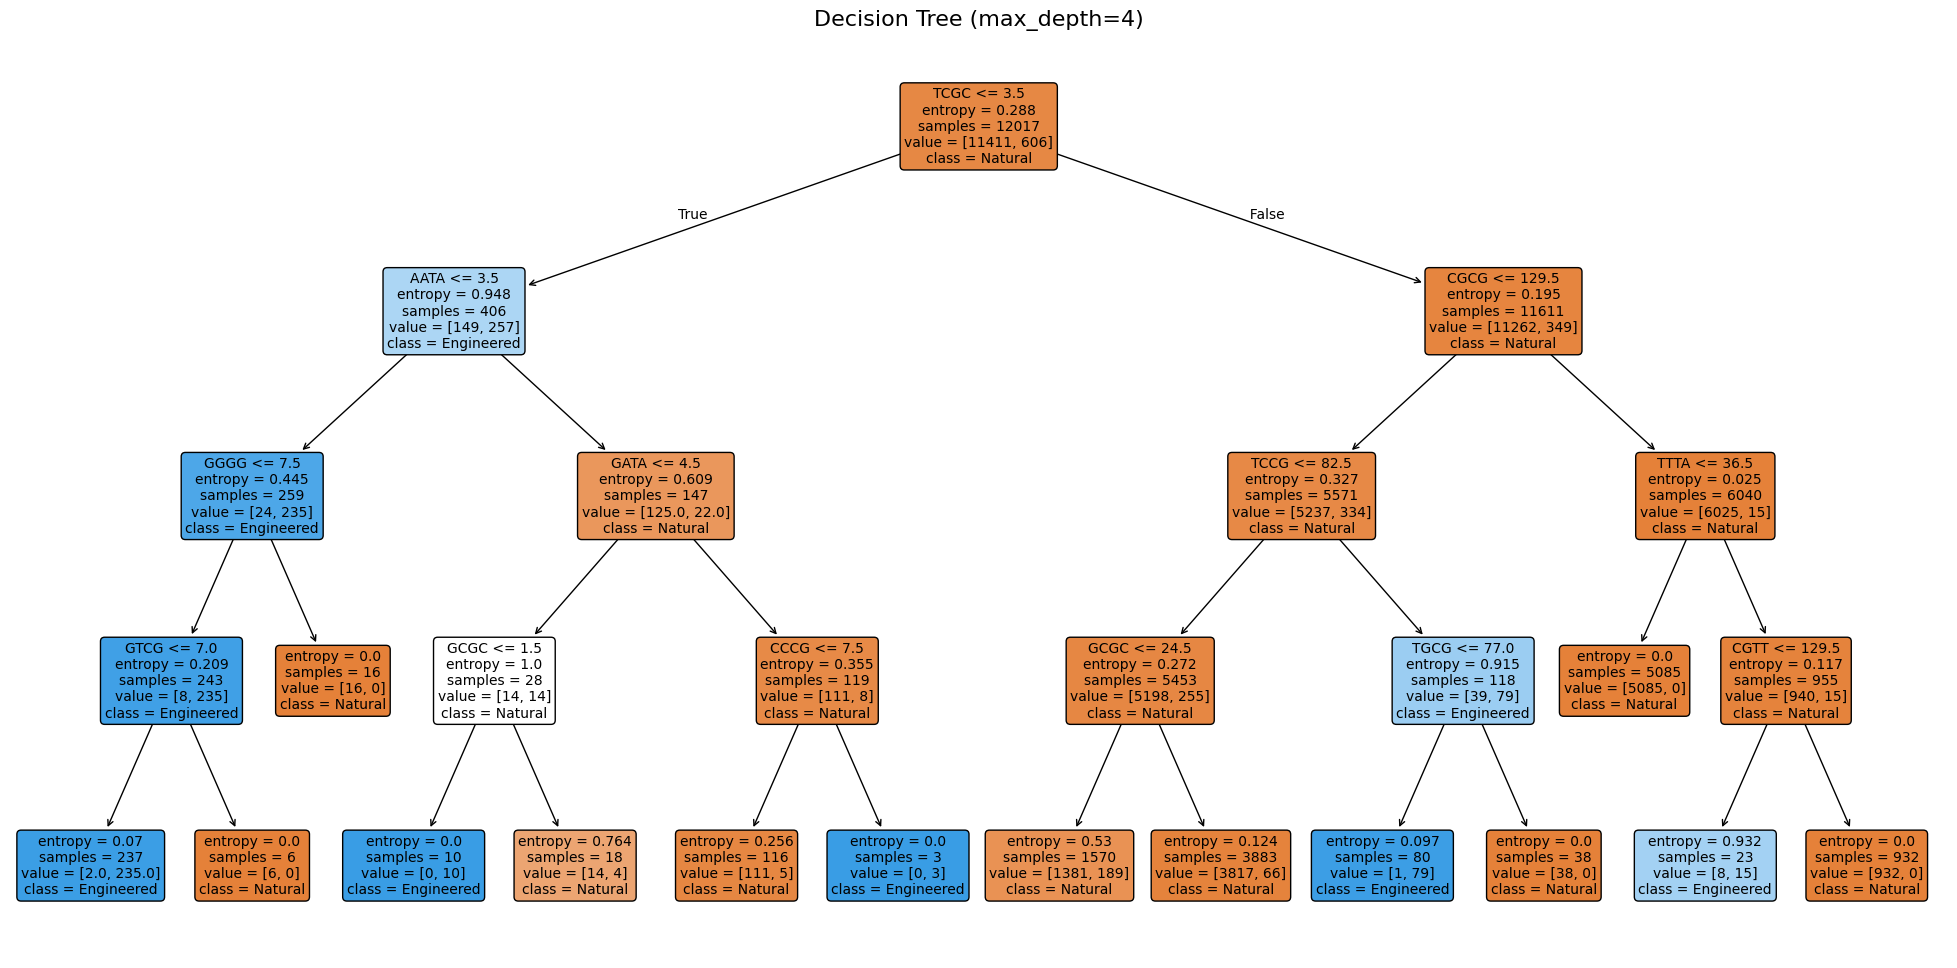


--- Model Evaluation ---
Accuracy on Test Set = 0.9711


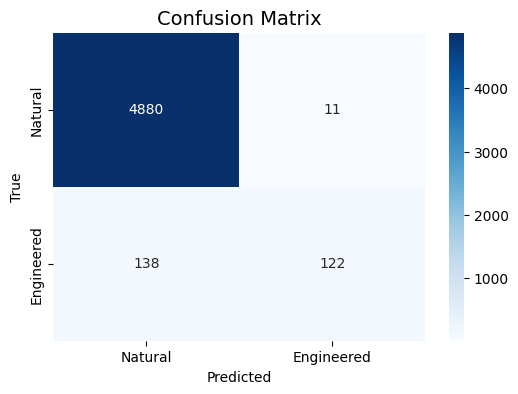


Classification Report:

              precision    recall  f1-score   support

     Natural       0.97      1.00      0.98      4891
  Engineered       0.92      0.47      0.62       260

    accuracy                           0.97      5151
   macro avg       0.94      0.73      0.80      5151
weighted avg       0.97      0.97      0.97      5151


--- A7: Decision Boundary in 2D ---
[INFO] Using random subsample of 500 points...
[INFO] Plotting grid of size (3289, 2384)...


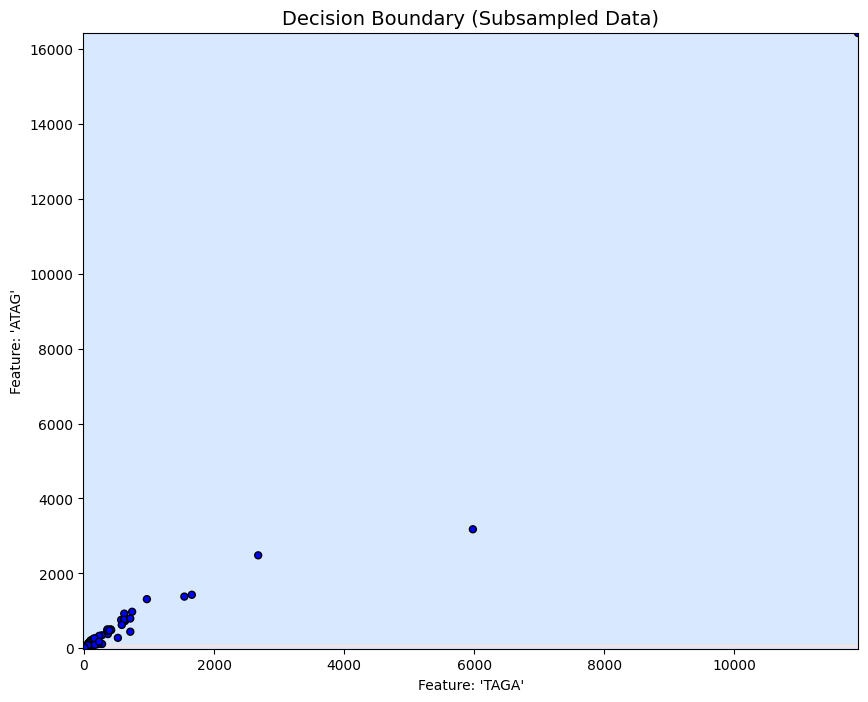

In [ ]:
# ======================================================================
# --- Lab 06: Decision Trees (Memory-Efficient Version) ---
# Colab-Optimized Version
# Assumes 'X' (k-mer counts) and 'y' (labels) are already loaded
# ======================================================================

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
np.random.seed(42)  # For reproducibility

# ======================================================================
# --- Utility Functions (A1, A2, A3, A4) ---
# ======================================================================

def calculate_entropy(y):
    """Entropy of a label distribution."""
    if len(y) == 0: return 0
    _, counts = np.unique(y, return_counts=True)
    p = counts / len(y)
    return -np.sum(p * np.log2(p + 1e-9))

def calculate_gini(y):
    """Gini index of a label distribution."""
    if len(y) == 0: return 0
    _, counts = np.unique(y, return_counts=True)
    p = counts / len(y)
    return 1 - np.sum(p**2)

def bin_feature(x, n_bins=10):
    """Bin continuous feature into discrete bins."""
    _, edges = np.histogram(x, bins=n_bins)
    return np.clip(np.digitize(x, bins=edges, right=False), 1, n_bins) - 1

def find_best_split(X, y, n_bins=10):
    """Find best feature based on Information Gain."""
    parent_entropy = calculate_entropy(y)
    best_gain, best_idx = -1, -1
    for f in range(X.shape[1]):
        binned = bin_feature(X[:, f], n_bins)
        weighted_child_entropy = 0
        for b in np.unique(binned):
            subset_y = y[binned == b]
            weight = len(subset_y) / len(y)
            weighted_child_entropy += weight * calculate_entropy(subset_y)
        info_gain = parent_entropy - weighted_child_entropy
        if info_gain > best_gain:
            best_gain, best_idx = info_gain, f
    return best_idx, best_gain

# ======================================================================
# --- Visualization Helper (A7) ---
# ======================================================================

def plot_decision_boundary(X2d, y2d, clf, feat_names):
    """Plot 2D decision boundary with memory-efficient grid."""
    cmap_light = ListedColormap(['#d8e8ff','#ffdede'])
    cmap_bold = ListedColormap(['#0000FF','#FF0000'])

    h = 5.0   # coarse grid → saves memory
    x_min, x_max = X2d[:, 0].min() - 10, X2d[:, 0].max() + 10
    y_min, y_max = X2d[:, 1].min() - 10, X2d[:, 1].max() + 10
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    print(f"[INFO] Plotting grid of size {xx.shape}...")
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.scatter(X2d[:, 0], X2d[:, 1], c=y2d,
                cmap=cmap_bold, edgecolor='k', s=25)
    plt.title("Decision Boundary (Subsampled Data)", fontsize=14)
    plt.xlabel(f"Feature: '{feat_names[0]}'")
    plt.ylabel(f"Feature: '{feat_names[1]}'")
    plt.show()

# ======================================================================
# --- Main Execution ---
# ======================================================================

if 'X' not in locals() or X.shape[0] == 0:
    print("ERROR: Please load 'X' and 'y' before running.")
else:
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y)

    # --- A1 ---
    print("\n--- A1: Entropy ---")
    print(f"Entropy of dataset = {calculate_entropy(y):.4f}")

    # --- A2 ---
    print("\n--- A2: Gini Index ---")
    print(f"Gini Index of dataset = {calculate_gini(y):.4f}")

    # --- A3 & A4 ---
    print("\n--- A3 & A4: Best Root Split ---")
    best_idx, info_gain = find_best_split(X_train, y_train)
    best_feature = get_kmer_features(K_VALUE)[best_idx]
    print(f"Best Feature = {best_feature} (idx {best_idx})")
    print(f"Information Gain = {info_gain:.4f}")

    # --- A6 ---
    print("\n--- A6: Decision Tree (sklearn) ---")
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=42)
    dt.fit(X_train, y_train)

    plt.figure(figsize=(25, 12))
    plot_tree(dt,
              feature_names=get_kmer_features(K_VALUE),
              class_names=['Natural', 'Engineered'],
              filled=True, rounded=True, fontsize=10)
    plt.title("Decision Tree (max_depth=4)", fontsize=16)
    plt.show()

    # --- Evaluation ---
    print("\n--- Model Evaluation ---")
    y_pred = dt.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy on Test Set = {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Natural','Engineered'],
                yticklabels=['Natural','Engineered'])
    plt.title("Confusion Matrix", fontsize=14)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=['Natural','Engineered']))

    # --- A7 ---
    print("\n--- A7: Decision Boundary in 2D ---")
    n_samples = 500
    if X.shape[0] > n_samples:
        print(f"[INFO] Using random subsample of {n_samples} points...")
        idx = np.random.choice(X.shape[0], n_samples, replace=False)
        X_plot, y_plot = X[idx], y[idx]
    else:
        X_plot, y_plot = X, y

    feat1, feat2 = best_idx, 50
    X2d = X_plot[:, [feat1, feat2]]
    feat_names2d = [get_kmer_features(K_VALUE)[feat1],
                    get_kmer_features(K_VALUE)[feat2]]

    dt2d = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt2d.fit(X2d, y_plot)

    plot_decision_boundary(X2d, y_plot, dt2d, feat_names2d)
